In [1]:
import numpy as np 
import pandas as pd 
import os
import torch
import wordcloud
import seaborn as sn
import matplotlib.pyplot as plt
import time
import seaborn as sn
from tqdm.notebook import tqdm

from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

######################### Configuration #######################

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

TRAINED_MODELS_FOLDER = 'trained_models'
if not os.path.exists(TRAINED_MODELS_FOLDER):
    os.makedirs(TRAINED_MODELS_FOLDER)

STATS_FOLDER = 'stats'
if not os.path.exists(STATS_FOLDER):
    os.makedirs(STATS_FOLDER)

ANALYSIS_FOLDER = 'analysis'   
if not os.path.exists(ANALYSIS_FOLDER):
    os.makedirs(ANALYSIS_FOLDER)

/kaggle/input/employee-review/test_set.csv
/kaggle/input/employee-review/employee_review_mturk_dataset_v10_kaggle.csv
/kaggle/input/employee-review/validation_set.csv
/kaggle/input/employee-review/employee_review_mturk_dataset_test_v6_kaggle.csv
/kaggle/input/employee-review/train_set.csv


In [2]:
######################### Setting random state for repeatability of results #######################
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [3]:
######################### Loading Datasets #######################

train_df = pd.read_csv('/kaggle/input/employee-review/train_set.csv')
train_df.set_index('id', inplace=True)

val_df = pd.read_csv('/kaggle/input/employee-review/validation_set.csv')
val_df.set_index('id', inplace=True)

test_df = pd.read_csv('/kaggle/input/employee-review/test_set.csv')
test_df.set_index('id', inplace=True)
    

######################### Create feature vectors #######################

tfidf_vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)

tfidf_train_vectors = tfidf_vectorizer.fit_transform(train_df.feedback)
tfidf_val_vectors = tfidf_vectorizer.transform(val_df.feedback)
tfidf_test_vectors = tfidf_vectorizer.transform(test_df.feedback)

tfidf_train_vectors_clean = tfidf_vectorizer.fit_transform(train_df.feedback_clean)
tfidf_val_vectors_clean = tfidf_vectorizer.transform(val_df.feedback_clean)
tfidf_test_vectors_clean = tfidf_vectorizer.transform(test_df.feedback_clean)

count_vectorizer = CountVectorizer()
count_train_vectors = count_vectorizer.fit_transform(train_df.feedback)
count_val_vectors = count_vectorizer.transform(val_df.feedback)
count_test_vectors = count_vectorizer.transform(test_df.feedback)

count_train_vectors_clean = count_vectorizer.fit_transform(train_df.feedback_clean)
count_val_vectors_clean = count_vectorizer.transform(val_df.feedback_clean)
count_test_vectors_clean = count_vectorizer.transform(test_df.feedback_clean)

ml_train_labels = train_df.label
ml_test_tfidf_vectors = tfidf_test_vectors
ml_test_count_vectors = count_test_vectors
ml_test_labels = test_df.label

In [4]:
######################### Defining helper functions #######################

def run_classifier_experiment(input_train_vectors, train_labels, classifier = svm.SVC(kernel='linear')):
    t0 = time.time()
    classifier.fit(input_train_vectors, train_labels)
    t1 = time.time()
    time_linear_train = t1-t0
    print("Training time: %fs" % (time_linear_train))
    return classifier

def run_classifier_test(classifier, input_val_vectors, val_labels, description="default_experiment"):
    t3 = time.time()
    prediction = classifier.predict(input_val_vectors)
    t2 = time.time()  
    time_linear_predict = t2-t3
    print("Prediction time: %fs" % (time_linear_predict))

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

    svm_val_report = classification_report(val_labels, prediction, output_dict=True, zero_division=0)

    weighted_avg_f1 = svm_val_report['weighted avg']['f1-score']
   
    test_plot = sn.heatmap(pd.DataFrame(svm_val_report).iloc[:-1, :].T, annot=True,cmap="YlGnBu", ax=ax[0], vmin=0, vmax=1)
    #test_plot.get_figure().savefig(STATS_FOLDER + f'/{description}.png')  

    unique_labels = np.unique(val_labels)
    cm_prediction = confusion_matrix(val_labels, prediction, labels=unique_labels)
    cm_plot = sn.heatmap(cm_prediction, annot=True, annot_kws={"size": 16},cmap="YlGnBu", ax=ax[1], vmin=0, vmax=25)
    #cm_plot.get_figure().savefig(STATS_FOLDER + f'/{description}_cm.png')
    fig.suptitle(description, fontsize=12)
    fig.show()

    fig.savefig(STATS_FOLDER + f'/{description}_stats.png')

    return prediction, val_labels, weighted_avg_f1

def validate_classic_model(model_description, classifier, train_vectors, train_labels, test_vectors, test_labels, model_results_df):
    print("Configuration: %s" % (model_description))
    classic_model = run_classifier_experiment(train_vectors, train_labels, classifier = classifier)
    test_preds, test_labels, test_weighted_avg_f1 = run_classifier_test(classic_model, test_vectors, test_labels, description=model_description)
    model_results_df.loc[len(model_results_df)] = [model_description, test_weighted_avg_f1]
    

In [5]:
######################### Model Evaluation Configuration #######################

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

classic_model_results_df = pd.DataFrame(columns=['model_configuration','weighted_avg_f1'])


Configuration: multinomialMB_alpha_.2_tfidf
Training time: 0.005164s
Prediction time: 0.000455s
Configuration: multinomialMB_alpha_.2_tfidf_clean
Training time: 0.002776s
Prediction time: 0.000615s
Configuration: multinomialMB_alpha_.2_count
Training time: 0.003944s
Prediction time: 0.001021s
Configuration: multinomialMB_alpha_.2_count_clean
Training time: 0.004808s
Prediction time: 0.000812s
Configuration: SVC_linear_C1.1_tfidf
Training time: 0.313941s
Prediction time: 0.055811s
Configuration: SVC_linear_C1.1_tfidf_clean
Training time: 0.311192s
Prediction time: 0.056035s
Configuration: SVC_linear_C1.1_count
Training time: 0.381249s
Prediction time: 0.065069s
Configuration: SVC_linear_C1.1_count_clean
Training time: 0.377880s
Prediction time: 0.064475s
Configuration: SVC_default_rbf_C2.5_tfidf
Training time: 0.338665s
Prediction time: 0.057874s
Configuration: SVC_default_rbf_C2.5_tfidf_clean
Training time: 0.339120s
Prediction time: 0.056394s
Configuration: SVC_default_rbf_C2.5_count


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Configuration: LogisticRegression_lbfgs_tfidf_clean
Training time: 0.101718s
Prediction time: 0.000713s
Configuration: LogisticRegression_lbfgs_count
Training time: 0.957968s
Prediction time: 0.000770s
Configuration: LogisticRegression_lbfgs_count_clean
Training time: 0.934770s
Prediction time: 0.000758s


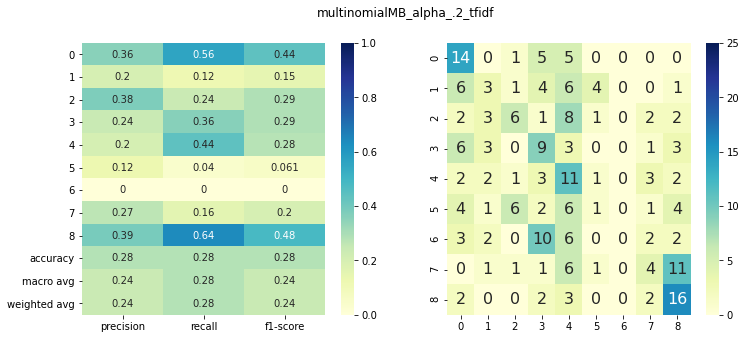

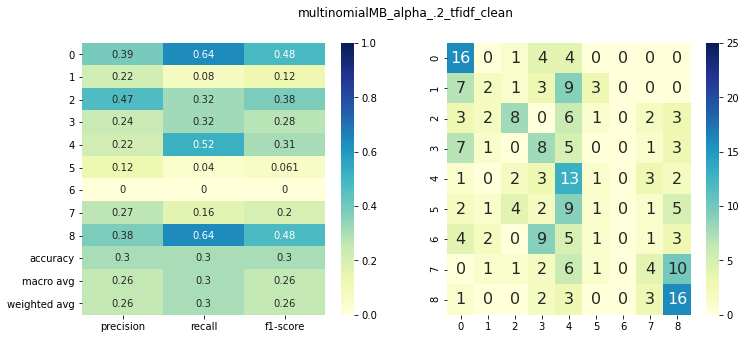

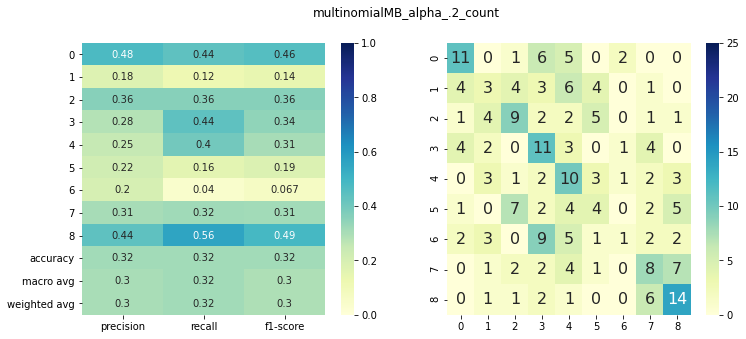

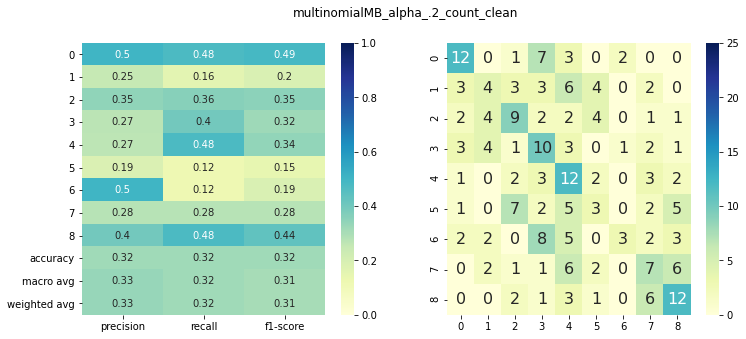

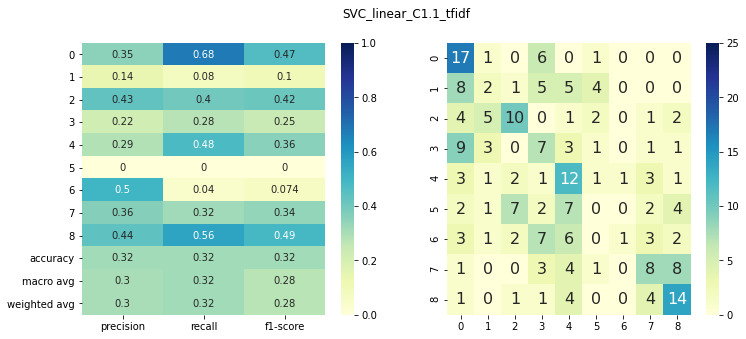

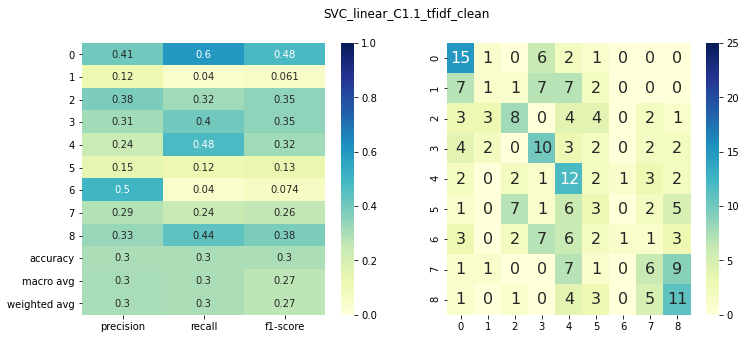

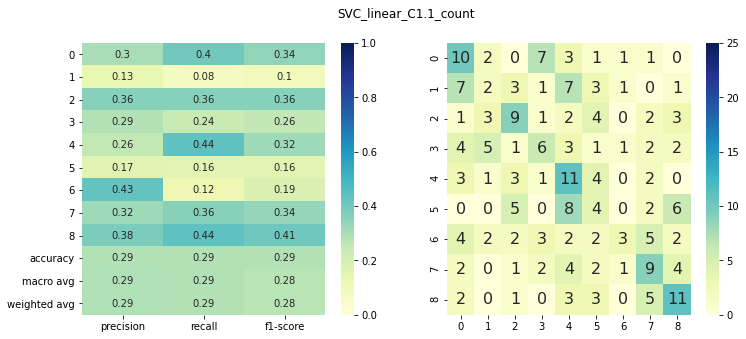

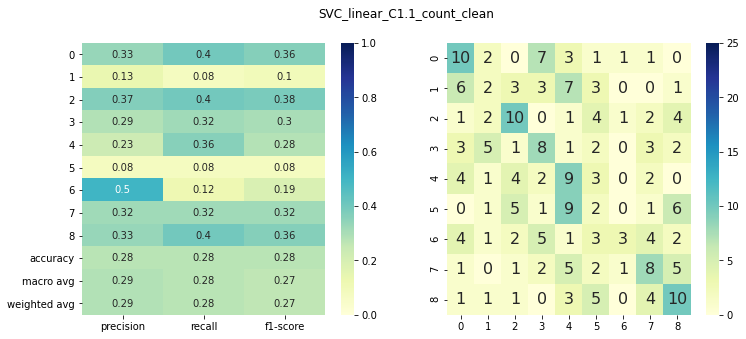

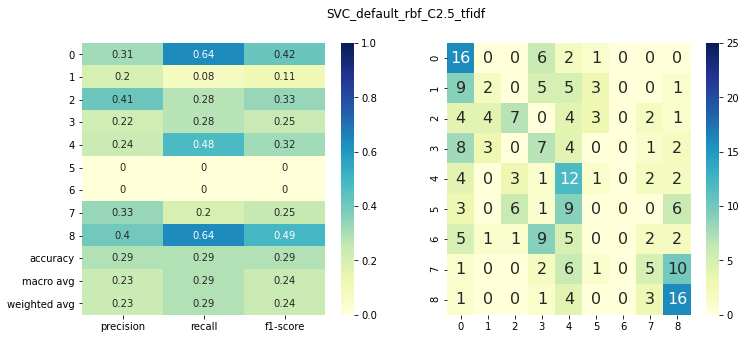

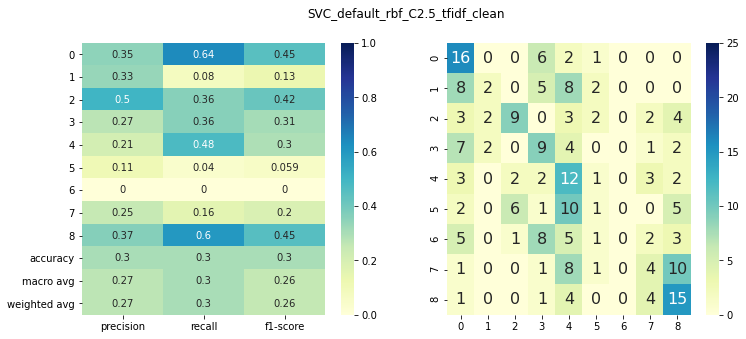

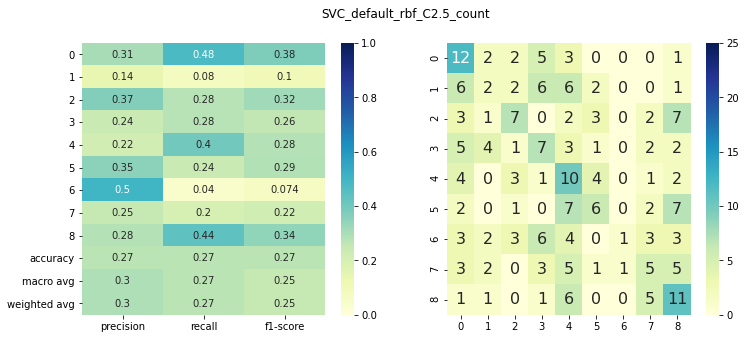

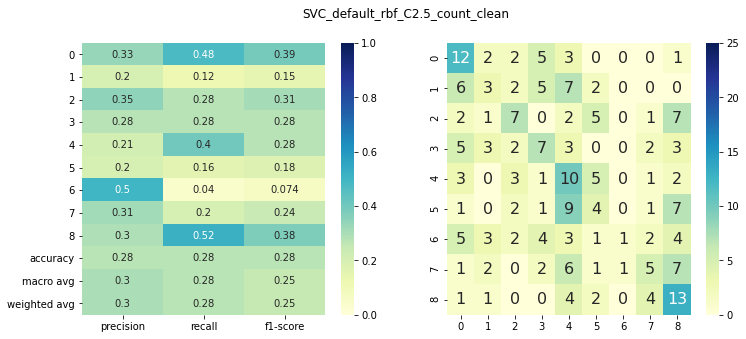

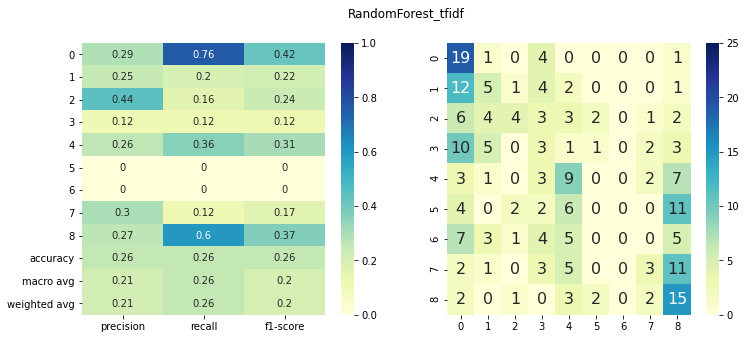

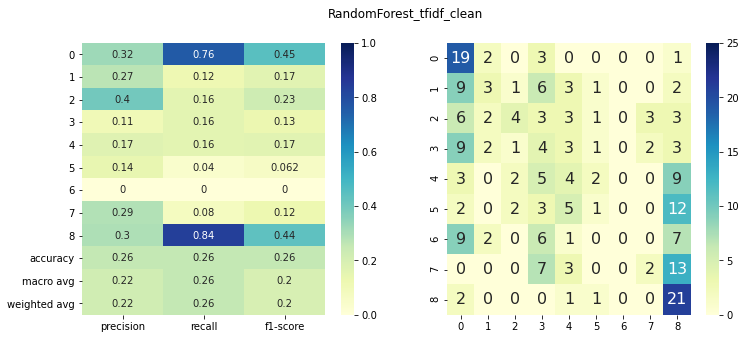

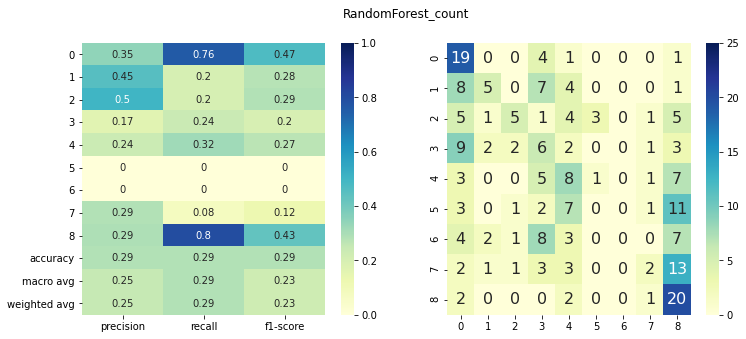

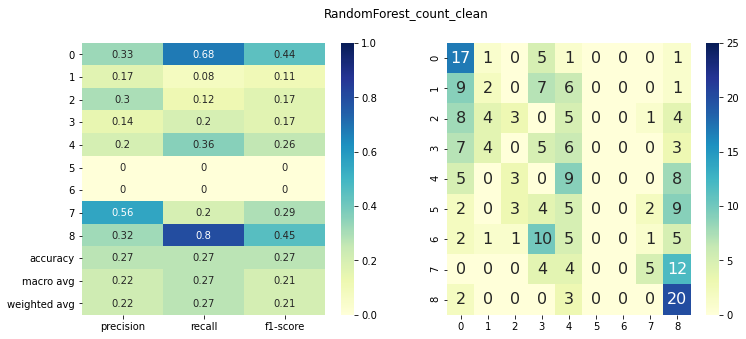

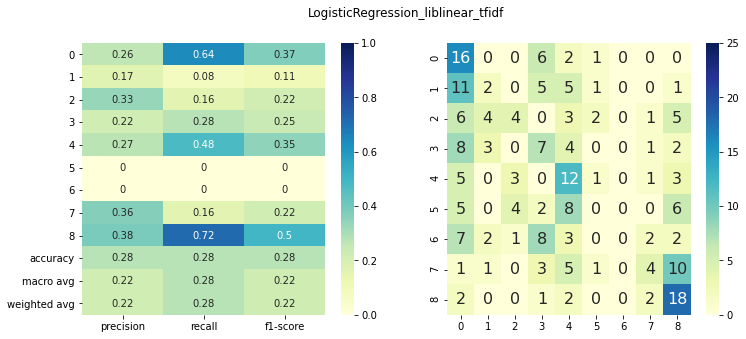

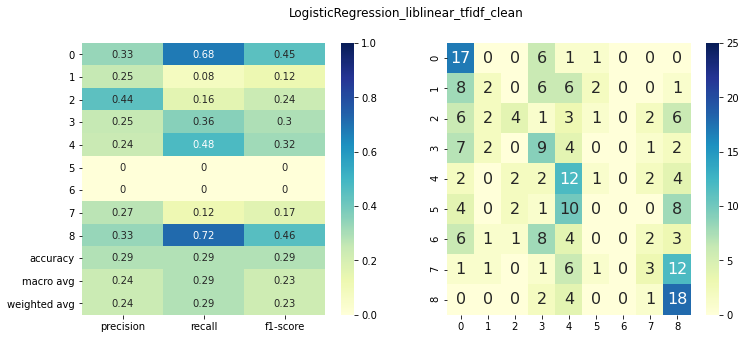

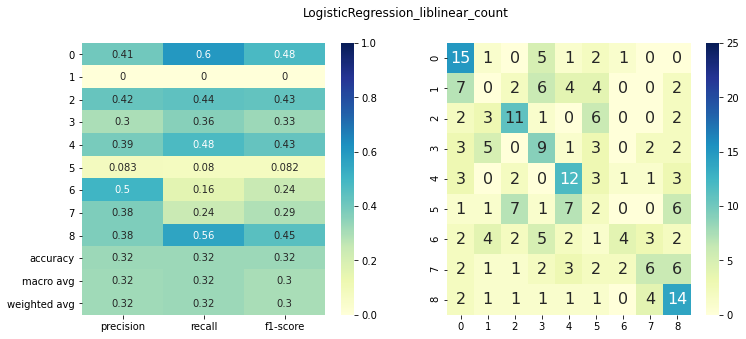

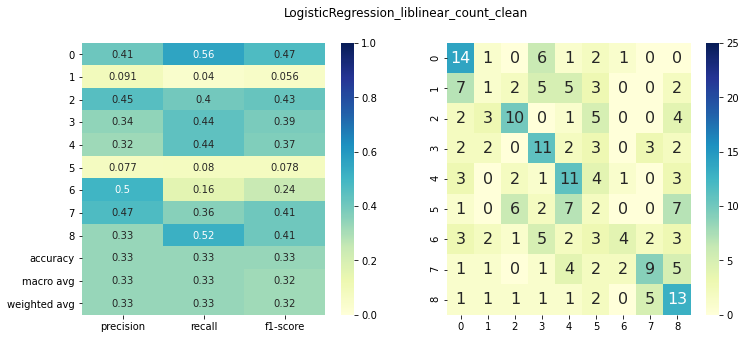

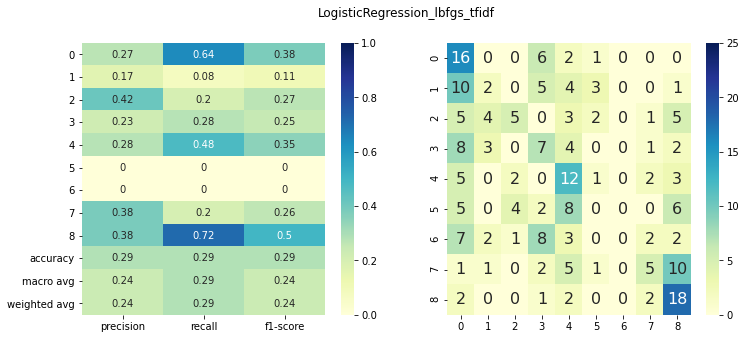

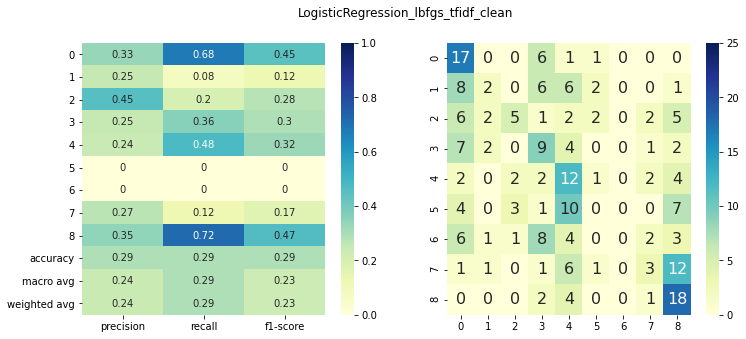

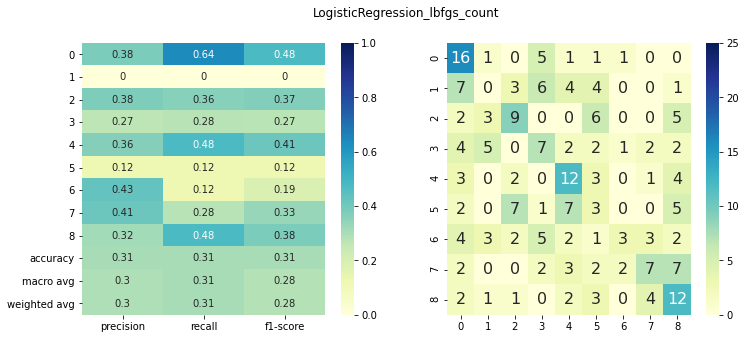

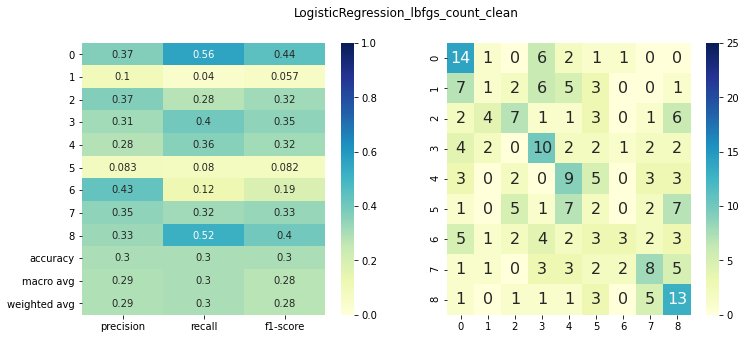

In [6]:
######################### Model Evaluation #######################

validate_classic_model(
    model_description = "multinomialMB_alpha_.2_tfidf",
    classifier = MultinomialNB(alpha=.2),
    train_vectors = tfidf_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_tfidf_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "multinomialMB_alpha_.2_tfidf_clean",
    classifier = MultinomialNB(alpha=.2),
    train_vectors = tfidf_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = tfidf_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "multinomialMB_alpha_.2_count",
    classifier = MultinomialNB(alpha=.2),
    train_vectors = count_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_count_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "multinomialMB_alpha_.2_count_clean",
    classifier = MultinomialNB(alpha=.2),
    train_vectors = count_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = count_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "SVC_linear_C1.1_tfidf",
    classifier = SVC(kernel='linear', C=1.1),
    train_vectors = tfidf_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_tfidf_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "SVC_linear_C1.1_tfidf_clean",
    classifier = SVC(kernel='linear', C=1.1),
    train_vectors = tfidf_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = tfidf_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "SVC_linear_C1.1_count",
    classifier = SVC(kernel='linear', C=1.1),
    train_vectors = count_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_count_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "SVC_linear_C1.1_count_clean",
    classifier = SVC(kernel='linear', C=1.1),
    train_vectors = count_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = count_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "SVC_default_rbf_C2.5_tfidf",
    classifier = SVC(kernel='rbf', C=2.5),
    train_vectors = tfidf_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_tfidf_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "SVC_default_rbf_C2.5_tfidf_clean",
    classifier = SVC(kernel='rbf', C=2.5),
    train_vectors = tfidf_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = tfidf_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "SVC_default_rbf_C2.5_count",
    classifier = SVC(kernel='rbf', C=2.5),
    train_vectors = count_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_count_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "SVC_default_rbf_C2.5_count_clean",
    classifier = SVC(kernel='rbf', C=2.5),
    train_vectors = count_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = count_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "RandomForest_tfidf",
    classifier = RandomForestClassifier(n_jobs=-1, random_state=17),
    train_vectors = tfidf_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_tfidf_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "RandomForest_tfidf_clean",
    classifier = RandomForestClassifier(n_jobs=-1, random_state=17),
    train_vectors = tfidf_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = tfidf_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "RandomForest_count",
    classifier = RandomForestClassifier(n_jobs=-1, random_state=17),
    train_vectors = count_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_count_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "RandomForest_count_clean",
    classifier = RandomForestClassifier(n_jobs=-1, random_state=17),
    train_vectors = count_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = count_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "LogisticRegression_liblinear_tfidf",
    classifier = LogisticRegression(fit_intercept=True, solver='liblinear'),
    train_vectors = tfidf_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_tfidf_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "LogisticRegression_liblinear_tfidf_clean",
    classifier = LogisticRegression(fit_intercept=True, solver='liblinear'),
    train_vectors = tfidf_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = tfidf_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "LogisticRegression_liblinear_count",
    classifier = LogisticRegression(fit_intercept=True, solver='liblinear'),
    train_vectors = count_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_count_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "LogisticRegression_liblinear_count_clean",
    classifier = LogisticRegression(fit_intercept=True, solver='liblinear'),
    train_vectors = count_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = count_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "LogisticRegression_lbfgs_tfidf",
    classifier = LogisticRegression(fit_intercept=True, solver='lbfgs'),
    train_vectors = tfidf_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_tfidf_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "LogisticRegression_lbfgs_tfidf_clean",
    classifier = LogisticRegression(fit_intercept=True, solver='lbfgs'),
    train_vectors = tfidf_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = tfidf_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "LogisticRegression_lbfgs_count",
    classifier = LogisticRegression(fit_intercept=True, solver='lbfgs', max_iter=200),
    train_vectors = count_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_count_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "LogisticRegression_lbfgs_count_clean",
    classifier = LogisticRegression(fit_intercept=True, solver='lbfgs', max_iter=200),
    train_vectors = count_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = count_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

In [7]:
from sklearn.model_selection import GridSearchCV

param_grid = {'bootstrap': [True],
     'max_depth': [6, 10],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [3, 5],
     'min_samples_split': [4, 6],
     'n_estimators': [100, 350]
    }
     

forest_clf = RandomForestClassifier()

forest_grid_search = GridSearchCV(forest_clf, param_grid, cv=5,
                                  scoring="accuracy",
                                  return_train_score=True,
                                  verbose=True,
                                  n_jobs=-1)

forest_grid_search.fit(tfidf_train_vectors, ml_train_labels)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   38.3s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [6, 10],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [3, 5],
                         'min_samples_split': [4, 6],
                         'n_estimators': [100, 350]},
             return_train_score=True, scoring='accuracy', verbose=True)

In [8]:
forest_grid_search.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 6,
 'n_estimators': 350}

In [ ]:
######################### Additional - gradient boost #######################
validate_classic_model(
    model_description = "gradient_boost_tfidf",
    classifier = GradientBoostingClassifier(random_state=seed_val, max_depth=10, max_features='auto', min_samples_leaf=3, min_samples_split=4, n_estimators=350),
    train_vectors = tfidf_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_tfidf_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "gradient_boost_tfidf_clean",
    classifier = GradientBoostingClassifier(random_state=seed_val, max_depth=10, max_features='auto', min_samples_leaf=3, min_samples_split=4, n_estimators=350),
    train_vectors = tfidf_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = tfidf_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "gradient_boost_count",
    classifier = GradientBoostingClassifier(random_state=seed_val, max_depth=10, max_features='auto', min_samples_leaf=3, min_samples_split=4, n_estimators=350),
    train_vectors = count_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_count_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "gradient_boost_clean",
    classifier = GradientBoostingClassifier(random_state=seed_val, max_depth=10, max_features='auto', min_samples_leaf=3, min_samples_split=4, n_estimators=350),
    train_vectors = count_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = count_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

Configuration: gradient_boost_tfidf
Training time: 81.263030s
Prediction time: 0.087523s
Configuration: gradient_boost_tfidf_clean
Training time: 80.617211s
Prediction time: 0.085105s
Configuration: gradient_boost_count


In [ ]:
######################### Present Final Results #######################

classic_model_results_df.index += 1 
classic_model_results_df.to_csv(STATS_FOLDER +'/classic_model_results.csv')
print(classic_model_results_df)

print('\nWinner:')

print(classic_model_results_df.loc[classic_model_results_df['weighted_avg_f1'] == classic_model_results_df['weighted_avg_f1'].max()])

print('End of execution')